<a href="https://colab.research.google.com/github/ParamAhuja/instruction_tuning/blob/main/DatasetLengthAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analayse the original hcc data

In [20]:
!unzip "/content/HCC_DATA_For_Interns.zip"

import pandas as pd
import os

df = pd.DataFrame(columns=["Name", "Input", "Output"])

for i in os.listdir("/content/Input"):

  with open (f"/content/Input/{i}", "r") as f:
    input = f.read()
    print("success: ", i)
  j = i.split(".")[0] + ".json"
  with open (f"/content/Output_HCC/{j}", "r") as f:
    output = f.read()
    print("success: ", j)
  data = [i.split(".")[0] , input, output ]
  df.loc[len(df)] = data
df

Archive:  /content/HCC_DATA_For_Interns.zip
   creating: Input/
  inflating: Input/170039.txt        
  inflating: Input/191804.txt        
  inflating: Input/170347.txt        
  inflating: Input/139806.txt        
  inflating: Input/188518.txt        
  inflating: Input/160997.txt        
  inflating: Input/164563.txt        
  inflating: Input/133465.txt        
  inflating: Input/138218.txt        
  inflating: Input/148915.txt        
  inflating: Input/118363.txt        
  inflating: Input/133797.txt        
  inflating: Input/132895.txt        
  inflating: Input/139858.txt        
  inflating: Input/170231.txt        
  inflating: Input/134082.txt        
  inflating: Input/198479.txt        
  inflating: Input/134739.txt        
  inflating: Input/196602.txt        
  inflating: Input/150324.txt        
  inflating: Input/156154.txt        
  inflating: Input/180080.txt        
  inflating: Input/124849.txt        
  inflating: Input/113219.txt        
  inflating: Input/15781

,Name,Input,Output
0,153601,Admission Date: [**2197-6-12**] Dischar...,"{\n ""clinical_findings"": {\n ""S06310..."
1,124750,Admission Date: [**2200-2-10**] Discharge...,"{\n ""clinical_findings"": {}\n}"
2,114051,Admission Date: [**2130-8-26**] Dischar...,"{\n ""clinical_findings"": {\n ""N179"":..."
3,119010,Admission Date: [**2180-10-29**] ...,"{\n ""clinical_findings"": {\n ""C50919..."
4,180080,Admission Date: [**2193-8-5**] D...,"{\n ""clinical_findings"": {\n ""I462"":..."
...,...,...,...
585,132347,Admission Date: [**2102-2-19**] Dischar...,"{\n ""clinical_findings"": {\n ""I4891""..."
586,197621,Admission Date: [**2117-1-16**] ...,"{\n ""clinical_findings"": {\n ""Z992"":..."
587,186490,Admission Date: [**2197-6-15**] ...,"{\n ""clinical_findings"": {\n ""B20"": ..."
588,181893,Admission Date: [**2152-11-25**] ...,"{\n ""clinical_findings"": {\n ""I259"":..."


In [22]:
from transformers import AutoTokenizer

base_model_id = "meta-llama/Llama-3.2-3B"

# Load the tokenizer from the base model
tokenizer = AutoTokenizer.from_pretrained(base_model_id)

# --- CRITICAL FIX: Ensure padding token is defined ---
# Llama models often don't have a padding token by default.
# We explicitly set it to the EOS token for batching.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id # Also set pad_token_id for explicit clarity

# Verify that pad_token is now set
print(f"Tokenizer loaded. Pad token: '{tokenizer.pad_token}', Pad token ID: {tokenizer.pad_token_id}")
if tokenizer.pad_token is None:
    raise ValueError("Padding token is still not set after attempting to assign it. Please check tokenizer configuration.")

Tokenizer loaded. Pad token: '<|end_of_text|>', Pad token ID: 128001


In [23]:
token_lengths = []
for idx, row in df.iterrows():
  combined_text = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

  ### Instruction:
  Provide structured ICD-10-CM codes with Monitoring, Evaluation, Assessment, and Treatment from the discharge note.

  ### Input:
  {row["Input"]}

  ### Response:
  {row["Output"]}"""
  tokenized_output = tokenizer(combined_text, add_special_tokens=True)
  token_ids = tokenized_output['input_ids']
  token_lengths.append(len(token_ids))

In [24]:
import numpy as np

min_token_length = np.min(token_lengths)
max_token_length = np.max(token_lengths)
mean_token_length = np.mean(token_lengths)
count_token_length = len(token_lengths)
std_dev_token_length = np.std(token_lengths)

In [25]:
print(f"Minimum Token Length: {min_token_length}")
print(f"Maximum Token Length: {max_token_length}")
print(f"Average Token Length: {mean_token_length}")
print(f"Number of Tokens: {count_token_length}")
print(f"Standard Deviation of Token Lengths: {std_dev_token_length}")

Minimum Token Length: 229
Maximum Token Length: 25489
Average Token Length: 6850.337288135594
Number of Tokens: 590
Standard Deviation of Token Lengths: 3968.358496799158


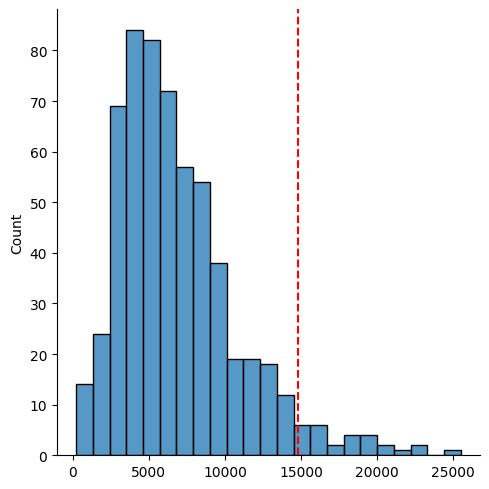

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(token_lengths)

# Add a vertical line after most of data is covered
plt.axvline(x=mean_token_length+2*std_dev_token_length, color='red', linestyle='--', label='cutoff')


# Analyze the tokenized "medical_evidence_dataset.json" by calculating stats.

In [27]:
import json

with open("/content/medical_evidence_dataset.json", 'r') as f:
    data = json.load(f)

In [28]:
from transformers import AutoTokenizer

base_model_id = "meta-llama/Llama-3.2-3B"

# Load the tokenizer from the base model
tokenizer = AutoTokenizer.from_pretrained(base_model_id)

# --- CRITICAL FIX: Ensure padding token is defined ---
# Llama models often don't have a padding token by default.
# We explicitly set it to the EOS token for batching.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id # Also set pad_token_id for explicit clarity

# Verify that pad_token is now set
print(f"Tokenizer loaded. Pad token: '{tokenizer.pad_token}', Pad token ID: {tokenizer.pad_token_id}")
if tokenizer.pad_token is None:
    raise ValueError("Padding token is still not set after attempting to assign it. Please check tokenizer configuration.")

Tokenizer loaded. Pad token: '<|end_of_text|>', Pad token ID: 128001


In [29]:
token_lengths = []
for entry in data:
    input_text = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

    ### Instruction:
    {entry["instruction"]}

    ### Input:
    {entry['input']}

    ### Response:
    {entry["output"]}"""
    tokenized_output = tokenizer(input_text, add_special_tokens=True)
    token_ids = tokenized_output['input_ids']
    token_lengths.append(len(token_ids))

In [30]:
import numpy as np

min_token_length = np.min(token_lengths)
max_token_length = np.max(token_lengths)
mean_token_length = np.mean(token_lengths)
count_token_length = len(token_lengths)
std_dev_token_length = np.std(token_lengths)

In [31]:
print(f"Minimum Token Length: {min_token_length}")
print(f"Maximum Token Length: {max_token_length}")
print(f"Average Token Length: {mean_token_length}")
print(f"Number of Tokens: {count_token_length}")
print(f"Standard Deviation of Token Lengths: {std_dev_token_length}")

Minimum Token Length: 118
Maximum Token Length: 7890
Average Token Length: 1139.522105263158
Number of Tokens: 3800
Standard Deviation of Token Lengths: 923.794687280783


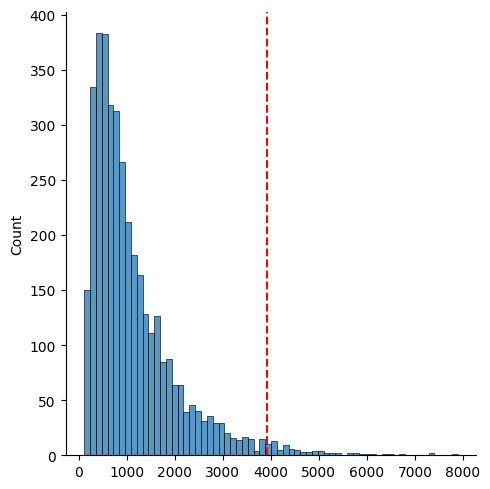

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(token_lengths)

# Add a vertical line after most of data is covered
plt.axvline(x=mean_token_length+3*std_dev_token_length, color='red', linestyle='--', label='x=10')
